In [1]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Import data

In [4]:
ROOT_PATH = 'Data_processed\\BZN-DE-LU\\'
data_2019 = pd.read_excel(ROOT_PATH+'Day_ahead_2019_DE_LU.xlsx')
data_2019.head()

,date,Hours,value
0,01/01/2019,00 - 01,10.07
1,01/01/2019,01 - 02,-4.08
2,01/01/2019,02 - 03,-9.91
3,01/01/2019,03 - 04,-7.41
4,01/01/2019,04 - 05,-12.55


In [5]:
data_2019['hour'] = data_2019['Hours'].apply(lambda x: x[:2])
data_2019 = data_2019.drop('Hours', axis=1)

<AxesSubplot:xlabel='date'>

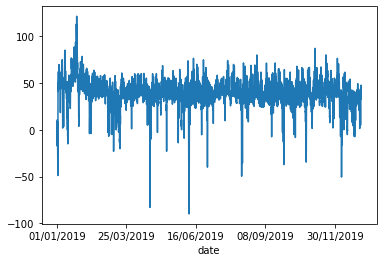

In [6]:
data_2019.set_index('date')['value'].plot()

In [7]:
data_2019['time'] = pd.to_datetime(data_2019['date']+data_2019['hour'], format="%d/%m/%Y%H")

In [8]:
data_2019 = data_2019.set_index('time')
serie = data_2019['value']

### Boxplot

#### Month variance

C:\Users\marti\anaconda3\envs\forecast\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='time', ylabel='value'>

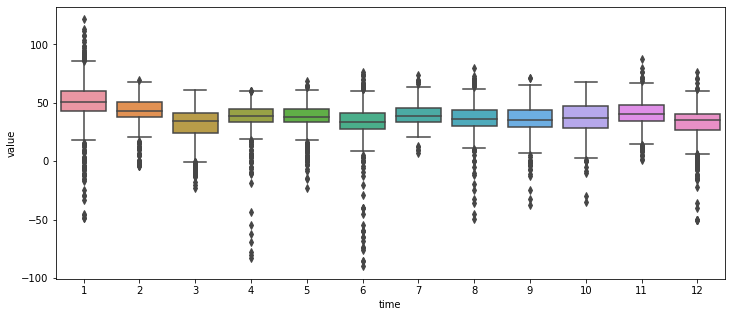

In [21]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(serie.index.month, serie, ax=ax)

#### Day variance

C:\Users\marti\anaconda3\envs\forecast\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='time', ylabel='value'>

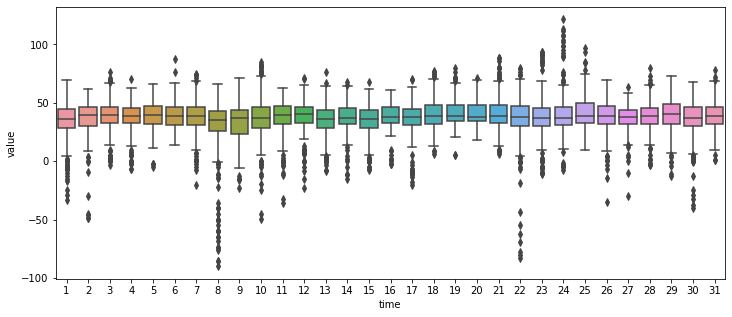

In [19]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(serie.index.day, serie, ax=ax)

 #### Hours variance

C:\Users\marti\anaconda3\envs\forecast\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='time', ylabel='value'>

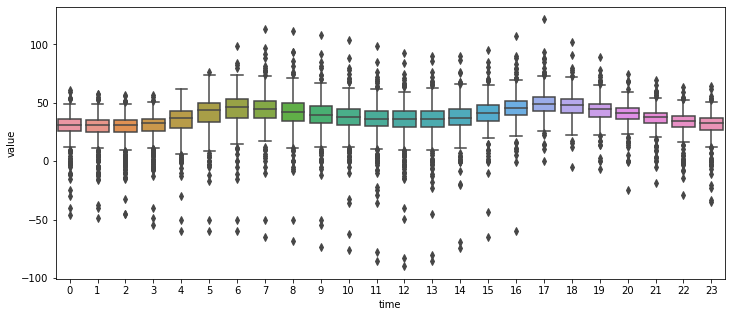

In [20]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(serie.index.hour, serie, ax=ax)

In [24]:
def plot_average_prices(data):
    
    """Plot monthly, daily and hourly averages of input data."""
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    data.groupby(data.index.month).mean().plot(ax=ax1, drawstyle='steps')
    ax1.set_title('Monthly Average', fontsize=14)
    ax1.set_ylabel('Day-Ahead price in €/MWh', fontsize=14)
    ax1.set_xlabel('Month of the year', fontsize=14)
    data.groupby(data.index.dayofweek).mean().plot(ax=ax2, drawstyle='steps')
    ax2.set_title('Weekly Average', fontsize=14)
    #ax2.set_ylabel('Day-Ahead price in €/MWh', fontsize=14)
    ax2.set_xlabel('Day of the week', fontsize=14)
    data.groupby(data.index.hour).mean().plot(ax=ax3, drawstyle='steps')
    ax3.set_title('Hourly Average', fontsize=14)
    #ax3.set_ylabel(' Day-Ahead price in €/MWh', fontsize=14)
    ax3.set_xlabel('Hour of the day', fontsize=14)
    
    ax1.legend().set_visible(False)
    ax2.legend().set_visible(False)
    ax3.legend().set_visible(False)

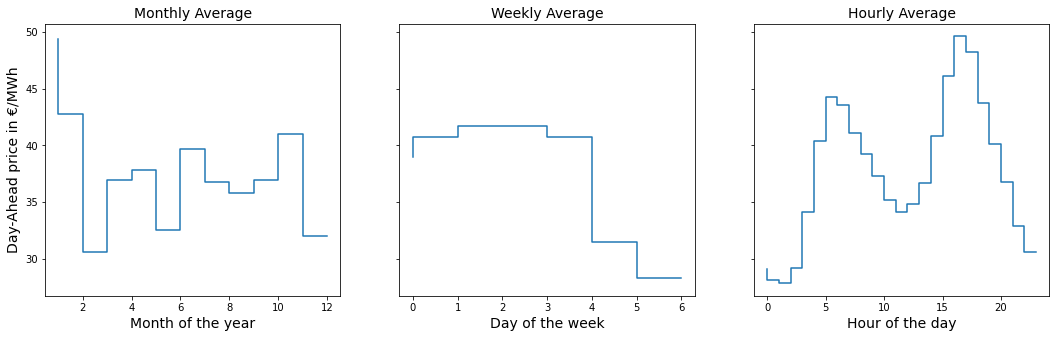

In [25]:
plot_average_prices(serie)

### Quick modelisation : moving average (rolling)

* moyenne mobile sur k dernière heures (de n-1 à n-11)
* La valeur à l'instant t n'est évidemment pris en compte (shift(1))
* On suppose alors qu'on a qu'une seule valeur à prédire (t).

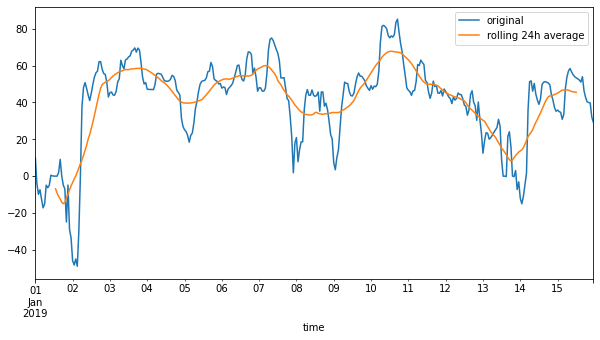

In [85]:
window=24
n_day=15
n_sample=n_day*24
serie[:n_sample].plot(label='original')
serie[:n_sample].shift(1).rolling(window, center=True).mean().plot(figsize=(10,5), label=f'rolling {window}h average')
plt.legend(loc='upper right')

## Explo - Statistics

https://towardsdatascience.com/can-we-predict-the-day-ahead-electricity-market-f532137fd5be

#### Check if the time series is stationary

* statistical properties of the time series change over times (esperance, std) ?

* Augmented Dickey-Fuller test /  Unit Root Test: ADF test
https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

In [92]:
result = adfuller(serie[:360], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.298362321119768
n_lags: 0.0004471220199623353
p-value: 0.0004471220199623353
Critial Values:
   1%, -3.44880082033912
Critial Values:
   5%, -2.869670179576637
Critial Values:
   10%, -2.5711012838861036


* p-value  < 0.05 we can reject null hypothesis of non-stationarity

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

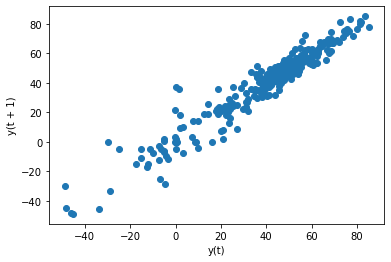

In [91]:
pd.plotting.lag_plot(serie[:360], lag=1)

In [82]:
15*24

360

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

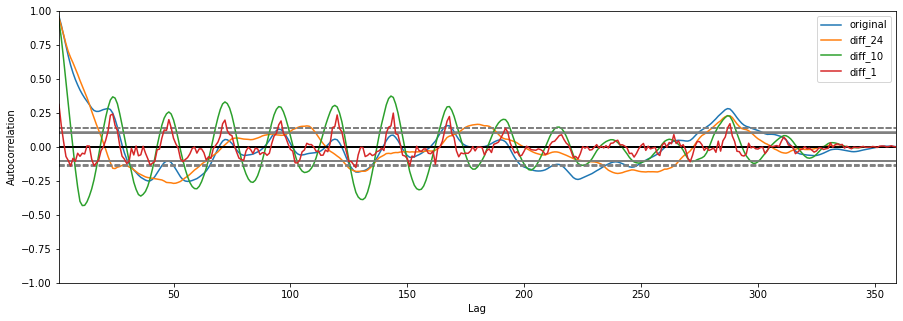

In [176]:
fig = plt.figure(figsize=(15,5))
autocorrelation_plot(serie[:360], label='original')
autocorrelation_plot(serie[:360].diff(periods=24)[24:], label='diff_24')
autocorrelation_plot(serie[:360].diff(periods=10)[10:], label='diff_10')
autocorrelation_plot(serie[:360].diff(periods=1)[1:], label='diff_1')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

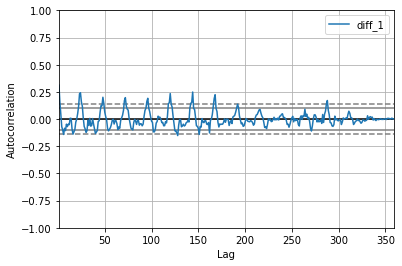

In [175]:
autocorrelation_plot(serie[:360].diff(periods=1)[1:], label='diff_1')

In [132]:
serie[:4]

time
2019-01-01 00:00:00    10.07
2019-01-01 01:00:00    -4.08
2019-01-01 02:00:00    -9.91
2019-01-01 03:00:00    -7.41
Name: value, dtype: float64

In [138]:
serie[:360].diff(periods=2)[:5]

time
2019-01-01 00:00:00      NaN
2019-01-01 01:00:00      NaN
2019-01-01 02:00:00   -19.98
2019-01-01 03:00:00    -3.33
2019-01-01 04:00:00    -2.64
Name: value, dtype: float64

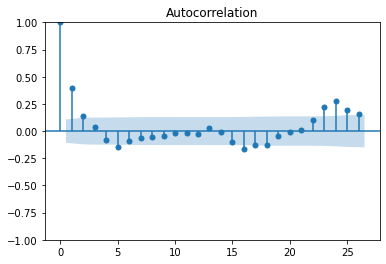

In [12]:
f = plot_acf(serie[:360].diff(periods=1)[24:])

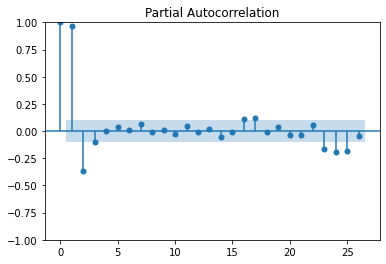

In [15]:
f = plot_pacf(serie[:360])

### Tests : for 15 days (360h)
* p = 5 
* q = 6

https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8

>Specifically, partial autocorrelations are useful in identifying the order of an autoregressive model. The partial autocorrelation of an AR(p) process is zero at lag p+1 and greater. If the sample autocorrelation plot indicates that an AR model may be appropriate, then the sample partial autocorrelation plot is examined to help identify the order. We look for the point on the plot where the partial autocorrelations essentially become zero. Placing a 95 % confidence interval for statistical significance is helpful for this purpose.

In [41]:
700/24

29.166666666666668

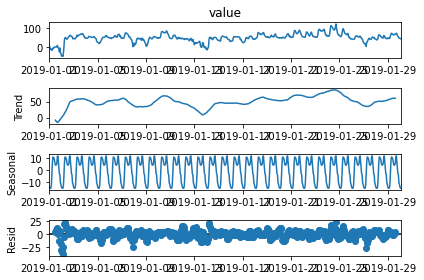

In [42]:
import statsmodels.api as sm
# one month
f = sm.tsa.seasonal_decompose(serie[:700]).plot()

In [44]:
result = sm.tsa.stattools.adfuller(serie)
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

p-value: 2.23143979466024e-18
Critical Values:
	1%: -3.431099968539641
	5%: -2.86187143613454
	10%: -2.5669464184887825


In [45]:
result

(-10.373570812120615,
 2.23143979466024e-18,
 37,
 8722,
 {'1%': -3.431099968539641,
  '5%': -2.86187143613454,
  '10%': -2.5669464184887825},
 48111.09531141576)

In [1]:
2421+371+179+106+40

3117

http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2019/02/Lecture_03.pdf

### Or Stationary Test with mean / std

In [ ]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

### Preprocess

Need to remove seasonality => not sure for our use case :https://stats.stackexchange.com/questions/395830/why-do-we-detrend-or-remove-seasonality-from-a-data-when-doing-time-series-analy

* Box-Cox transformation : uniform seasonality peaks

### ARIMA models

#### AR model

https://otexts.com/fpp2/AR.html
How much of the current price is dictated by the previous prices and how much further back does this go

In [150]:
from statsmodels.tsa.arima.model import ARIMA

ARIMA=(p,d,q)

In [181]:
X_set = serie[:360] 
train, test = X_set[0:200] , X_set[200:len(X_set)]
history = [x for x in train]
predictions = []
predictionslower = []
predictionsupper = []
model = ARIMA(history, order=(2,1,10))
model_fit = model.fit()
forecast= model_fit.forecast(5)
#obs = test[k]
#history.append(obs)

In [182]:
print(f"forecast : {forecast}")
print(f"true : {X_set[:5]}")

forecast : [53.40267213 54.08481012 53.67065267 51.74662657 49.73255767]
true : time
2019-01-01 00:00:00    10.07
2019-01-01 01:00:00    -4.08
2019-01-01 02:00:00    -9.91
2019-01-01 03:00:00    -7.41
2019-01-01 04:00:00   -12.55
Name: value, dtype: float64


https://towardsdatascience.com/multi-step-time-series-forecasting-with-arima-lightgbm-and-prophet-cc9e3f95dfb0

In [ ]:
def chart_creation(df1):
    df1['forecast'] = df1['forecast'].shift(200)
    df1['lower'] = df1['lower'].shift(200)
    df1['upper'] = df1['upper'].shift(200)
    df1['date_time'] = df['date_time']
    df1.fillna({x:0 for x in ['data', 'forecast', 'lower', 'upper']}, inplace=True)
    test = df1['data']
    std_err = df1['forecast'].sem()
    predictions = df1['forecast'][200:].values
    lower = df1['lower'][200:].values
    upper = df1['upper'][200:].values
    g = np.arange(len(predictions))
    plt.plot(df1['forecast'][200:], color='red', label='Arima Forecast')
    plt.plot(test, color='blue', label='Real Data')
    plt.fill_between(g+200 ,lower, upper, alpha=0.25, interpolate=True, color='red', label='95% confidence interval')
    #plt.xticks(df1.index.values, df1['date_time'], rotation=45, ha='right')
    plt.xlabel('Time (h)')
    plt.ylabel('£ / Mwh')
    plt.title('Day Ahead Electricity Pricing')
    plt.legend(loc='upper left')
    plt.show()

* Here p is the order of the autoregressive model(number of time lags)
* d is the degree of differencing(number of times the data have had past values
subtracted)
* q is the order of moving average model

https://github.com/hhamud/Arima-Forecasting/blob/master/arima_forecasting.py

Manually fitting a model. There are heuristics for choosing the parameters of an
ARIMA model, where parsimony is paramount. One popular and longstanding
method is the Box-Jenkins method, which is an iterative multistep process:
1. Use your data, visualizations, and underlying knowledge to select a class of
model appropriate to your data.
2. Estimate the parameters given your training data.
3. Evaluate the performance of your model based on your training data and tweak
the parameters of the model to address the weaknesses you see in the perfor‐
mance diagnostics

>The residuals in Figure 6-10 show particularly large PACF values, suggesting that we
have not fully described the autoregressive behavior. For this reason, we build out the
model by adding a higher-order AR component, testing an ARIMA(2, 0, 1)

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

https://www.kaggle.com/code/rohanrao/a-modern-time-series-tutorial

https://www.datacamp.com/community/tutorials/lstm-python-stock-market

https://www.kaggle.com/code/hsankesara/time-series-analysis-and-forecasting-using-arima